# Reduced demand

## Bringing the data

In [28]:
%reset -f
import copy
import math
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import combinations
from disaggregator import config, data, spatial, plot
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

### Bring the shapes

In [29]:
nuts = data.database_shapes()
nuts = nuts.drop(columns = ["id_ags", "gen", "fl_km2"])

###  Bring the connections

In [30]:
with open("project_data/in/germanPipesMerged.json", 'r', encoding = 'utf-8') as file:
    pipes = json.load(file)

with open("project_data/in/germanPipesRaw.json", 'r', encoding = 'utf-8') as file:
    pipes2 = json.load(file)

coords = []
listPipesLengths = []

for p in pipes:
    if (p["geometry"]["coordinates"] in coords): continue
    coords.append(p["geometry"]["coordinates"])
    listPipesLengths.append(p["properties"]["param"]["length_km"])

for p in pipes2:
    if (p["geometry"]["coordinates"] in coords): continue
    pipes.append(p)
    listPipesLengths.append(p["properties"]["param"]["length_km"])

pPlots = []

for p in pipes:
    pPlots.append(LineString( p["geometry"]["coordinates"] ))

pPlots = gpd.GeoDataFrame(geometry = pPlots, crs = "EPSG:4326")
pPlots = pPlots.to_crs("EPSG:25832")

finalPipes = gpd.GeoDataFrame(columns = ["origin", "destination"])
finalPipes["origin"]      = ["XX"] * len(pPlots)
finalPipes["destination"] = ["XX"] * len(pPlots)

for index, row in finalPipes.iterrows():
    if (not "nuts_id_3" in pipes[index]["properties"]["param"] or len(pipes[index]["properties"]["param"]["nuts_id_3"]) == 1): continue # Do not continue if there are no nuts 3 info

    if (pipes[index]["properties"]["param"]["nuts_id_3"][0][0:2] == "DE"): row["origin"] = pipes[index]["properties"]["param"]["nuts_id_3"][0]
    if (pipes[index]["properties"]["param"]["nuts_id_3"][1][0:2] == "DE"): row["destination"] = pipes[index]["properties"]["param"]["nuts_id_3"][1]

def get_start_end_points(line):
    return {'Start': line.coords[0], 'End': line.coords[-1]}

# Apply the function to create a new GeoDataFrame with start and end points
points_data = pPlots['geometry'].apply(get_start_end_points).apply(pd.Series)

# Create a new GeoDataFrame with the points
start_Points = gpd.GeoDataFrame(geometry=[Point(x) for x in points_data['Start']], crs="EPSG:25832")
end_Points   = gpd.GeoDataFrame(geometry=[Point(x) for x in points_data['End']], crs="EPSG:25832")

resultStart = gpd.sjoin(start_Points, nuts, how="left").rename(columns={'geometry': 'geomS', 'index_right': 'indexS'})
resultEnd   = gpd.sjoin(end_Points, nuts, how="left").rename(columns={'geometry': 'geomE', 'index_right': 'indexE'})

joinPipes = pd.concat([resultStart, resultEnd], axis = 1)
joinPipes = joinPipes.reset_index(drop = True)
joinPipes = joinPipes.drop(columns = ["geomS", "geomE"]).rename(columns = {"indexS": "origin", "indexE": "destination"})

for index, row in finalPipes.iterrows():
    if (row["origin"] == "XX" and type(joinPipes.loc[index, "origin"]) == type("")):
        row["origin"] = joinPipes.loc[index, "origin"]
    if (row["destination"] == "XX" and type(joinPipes.loc[index, "destination"]) == type("")):
        row["destination"] = joinPipes.loc[index, "destination"]

indexesToInvert = []

for p in pipes:
    if ("is_bothDirection" in p["properties"]["param"] and p["properties"]["param"]["is_bothDirection"]): indexesToInvert.append(index)

for index in indexesToInvert:
    finalPipes.loc[len(finalPipes)] = [finalPipes.loc[index, "destination"],finalPipes.loc[index, "origin"]]
    listPipesLengths.append(listPipesLengths[index])

indexesToRemove = [] # These indexes indicate pipes that go from a district to itself

for index, row in finalPipes.iterrows():
    if (row["origin"] == row["destination"]): indexesToRemove.append(index)

finalPipes = finalPipes.drop(indexesToRemove)

with open("project_data/out/finalPipes.json", 'w') as file:
    json.dump(finalPipes.to_dict(), file)

for i in range(len(indexesToRemove) - 1, -1, -1):
    del listPipesLengths[indexesToRemove[i]]

pipesDestination = nuts.copy().drop(columns = ["geometry"])

pipesDestination["comingIn"] = np.zeros(401)
pipesDestination["outGoing"] = np.zeros(401)

for _, p in finalPipes.iterrows():
    pipesDestination.loc[p["origin"], "outGoing"] = 1
    pipesDestination.loc[p["destination"], "comingIn"] = 1

with open("project_data/out/pipesDestination.json", 'w') as file:
    json.dump(pipesDestination.to_dict(), file)

### Bring the pipes' lengths

In [31]:
pipesLengths = {}

index = 0
for _, row in finalPipes.iterrows():
    if (row["origin"] not in pipesLengths): pipesLengths[row["origin"]] = {}

    pipesLengths[row["origin"]][row["destination"]] = listPipesLengths[index]
    index += 1

with open("project_data/out/lengths.json", 'w') as file:
    json.dump(pipesLengths, file)

## Hydrogen demand

### Residential demand

We bring the current yearly gas usage for every building type per district. We will compute separately the gas demand for hot water, cooking and space heating. We will then distribute the yearly gas demand across the year with the space heating and hot water load monthy profile. Finally, the criteria for hydrogen boilers will be applied.

#### Households per size per districts

The household's size will be used to scale the gas usage for cooking

In [32]:
from disaggregator import data
from disaggregator.config import get_config

df = data.database_get('spatial', table_id=14, force_update = False)
df = df.assign(nuts3=lambda x: x.id_region.map(data.dict_region_code()),
                    hh_size=lambda x: x.internal_id.str[0].astype(int)) .loc[lambda x: x.hh_size != 0] .pivot_table(values='value', index='nuts3', columns='hh_size',aggfunc='sum')

cfg = get_config()
year = cfg['base_year']
gas_nuts0 = spatial.gas_consumption_HH(year=year)

hh_size = df.copy()

hh_size[3] = hh_size[3] + hh_size[4] + hh_size[5]
hh_size.drop(columns = [4, 5], inplace = True)

HH_dict = {
    1 : '1FH',
    2 : 'TH',
    3 : 'MFH',
    6 : 'MSB'
}

hh_size.rename(columns = HH_dict, inplace = True)

hh_size.reset_index(inplace=True)
hh_size.rename(columns={'index': 'nuts3'}, inplace=True)


# Melting the DataFrame
melted_df = hh_size.melt(id_vars=['nuts3'], var_name='building_type', value_name='value')
melted_df.sort_values(by='nuts3', inplace=True)
melted_df.reset_index(drop=True, inplace=True)

norm_HH = melted_df.copy()
norm_HH["value"] = melted_df["value"] / melted_df["value"].values.sum()
norm_HH["value"] *= gas_nuts0['Cooking']

#### Population per district

The population is used to scale the gasUse for hot water heating.

In [33]:
# Define multiplication factors
multipliers = {
    '1FH': 1,
    'TH':  1,
    'MFH': 11,
    'MSB': 32
}

pop_df = melted_df.copy()
# Apply multiplications based on building_type
pop_df['multiplier'] = melted_df['building_type'].map(multipliers)
pop_df['value'] = melted_df['value'] * pop_df['multiplier']
pop_df.drop(columns = ["multiplier"], inplace=True)

norm_pop = pop_df.copy()
norm_pop["value"] = pop_df["value"] / pop_df["value"].sum()
norm_pop["value"] *= gas_nuts0['HotWater']

#### Living space heating

The living space is used to scale the gas usage for living space heating, which is given in kWh/m2. We then store it into the dataframe `SH` that will later be multiplied times the profile of the space heating.

In [34]:
df_living_space = spatial.living_space(aggregate=False, year=2018,
                          internal_id=[None, None, 11, 1]).drop(columns = ['heating_system', 'non_empty_building']).replace()

buildingDict = {'2FH' : 'TH',
                'MFH_03_06': 'MFH',
                'MFH_07_12': 'MSB',
                'MFH_13_99': 'MSB'}

df_living_space.replace(buildingDict, inplace=True)

df_living_space = df_living_space.groupby(['nuts3', 'building_type']).mean()

# uniform non-matching vintage sections
new_m2_vintages = {'A_<1900':     'A_<1948',
                   'B_1900-1945': 'A_<1948',
                   'C_1946-1960': 'B_1949-1968',
                   'D_1961-1970': 'B_1949-1968',
                   'E_1971-1980': 'C_1969-1985',
                   'F_1981-1985': 'C_1969-1985',
                   'G_1986-1995': 'D_1986-1995',
                   'H_1996-2000': 'E_1996-2000',
                   'I_2001-2005': 'F_>2000',
                   'J_2006-2011': 'F_>2000',
                   'K_2012': 'F_>2000',
                   'L_2013': 'F_>2000',
                   'M_2014': 'F_>2000',
                   'N_2015': 'F_>2000',
                   'O_2016': 'F_>2000',
                   'P_2017': 'F_>2000',
                   'Q_2018': 'F_>2000',
                   'R_2019': 'F_>2000'}
new_dem_vintages = {'A_<1859':     'A_<1948',
                    'B_1860-1918': 'A_<1948',
                    'C_1919-1948': 'A_<1948',
                    'D_1949-1957': 'B_1949-1968',
                    'E_1958-1968': 'B_1949-1968',
                    'F_1969-1978': 'C_1969-1985',
                    'G_1979-1983': 'C_1969-1985',
                    'H_1984-1994': 'D_1986-1995',
                    'I_1995-2001': 'E_1996-2000',
                    'J_2002-2009': 'F_>2000'}

# Status Quo buildings
df1 = (spatial.heat_demand_buildings(table_id=56, year=2018,
                             internal_id=[None, None, 1, 1])
       .replace(dict(vintage_class=new_dem_vintages))
       .loc[lambda x: x.vintage_class != 'A_<1948'])

# df2 = refurbished buildings
df2 = (spatial.heat_demand_buildings(table_id=56, year=2018,
                             internal_id=[None, None, 1, 2])
       .replace(dict(vintage_class=new_dem_vintages))
       .loc[lambda x: x.vintage_class == 'A_<1948'])
df_heat_dem = pd.concat([df1, df2])

# FOR HEATING WE HAVE THE FOLLOWING : ['1FH', 'TH', 'MFH', 'MSB']
# FOR LIVING SPACE WE HAVE : ['1FH', '2FH', 'MFH_03_06', 'MFH_07_12', 'MFH_13_99']

df_heat = df_heat_dem
df_heat['building_type'] = df_heat_dem['building_type'].replace(buildingDict, regex=True)

df_heat = df_heat.groupby(['nuts3', 'building_type']).sum() / 1e3 # kWh -> MWh

SH = df_heat.copy()

SH['value'] = 2.161 * df_living_space['value'].multiply(df_heat['value'], fill_value=0)
SH.reset_index(drop=False, inplace=True)

#### Putting the constant gas demand together

`DHW` will hold the gas demand from cooking and hot water needs. They are grouped together since they are both relatively constant and can follow the profile of hot water.

In [35]:
DHW = pd.merge(norm_HH, norm_pop, on=['nuts3', 'building_type'], suffixes=(' HH', ' pop'))
DHW['value'] = DHW['value HH'] + DHW['value pop']
DHW.drop(columns = ['value HH', 'value pop'], inplace=True)

DHW.head()

,nuts3,building_type,value
0,DE111,1FH,39211.865078
1,DE111,MFH,215749.346691
2,DE111,MSB,38867.777174
3,DE111,TH,26414.347221
4,DE112,1FH,15979.466781


#### Bringing the load profiles

To simulate the varying load as a function of the month, we will bring two different load profiles :

 - `DHW_profile` which illustrates the Hot Water demand profile as a function of the month. It stays relatively the same. We can make the assumption that the profile for cooking is the same.
 
 - `SH_profile` represents the gas demand profile for Space Heating.

In [36]:
DHW_profile = pd.read_csv('project_data/in/HeatLoadProfile/DHW_profile.csv', index_col='nuts3')
SH_profile  = pd.read_csv('project_data/in/HeatLoadProfile/SH_profile.csv', index_col='nuts3')

DHW_t = pd.merge(DHW, DHW_profile, on='nuts3')
SH_t  = pd.merge(SH , SH_profile,  on='nuts3')

# Multiply yearly value by the percentage for each period
for period in range(1, 13):
    DHW_t[f'value {period}'] = DHW_t['value'] * DHW_t[f'Period {period}']
    DHW_t.drop(columns = [f'Period {period}'], inplace = True)
    
    SH_t[f'value {period}'] = SH_t['value'] * SH_t[f'Period {period}']
    SH_t.drop(columns = [f'Period {period}'], inplace = True)

DHW_t.drop(columns=['value'], inplace=True)
SH_t.drop(columns=['value'], inplace=True)

#### Final merge

Now that all the load profiles have been applied, we can simplify it into a single DataFrame that has the demand in MWh per month.

In [37]:
nuts_vals = list(nuts.index)

mergedDemand = SH_t.copy() # We start with the Space Heating demand, and then add the hot water and cooking demand

for n in nuts_vals:                       # For each district
    for b in ['1FH', 'TH', 'MFH', 'MSB']: # For each type of building
        for t in range(1, 13):            # For each period
            sh_pos = (SH_t['nuts3'] == n) & (SH_t['building_type'] == b)  # Index of the row with these conditions
            hw_pos = (DHW_t['nuts3'] == n) & (DHW_t['building_type'] == b)
            col_name = f'value {t}'

            # Perform addition and assignment using .loc with boolean indexing
            mergedDemand.loc[sh_pos, col_name] += DHW_t.loc[hw_pos, col_name].values

mergedDemand.head()

,nuts3,building_type,value 1,value 2,value 3,value 4,value 5,value 6,value 7,value 8,value 9,value 10,value 11,value 12
0,DE111,1FH,37488.912803,34857.268299,25640.227370,15810.025358,5651.191015,3407.379958,3267.408191,3293.111510,5052.800507,15646.869360,27524.407927,35018.563862
1,DE111,MFH,82174.339685,77391.970092,59997.135844,41535.536176,22453.931743,18240.639099,17977.751916,18026.026460,21332.664007,41226.533800,63535.898910,77614.109305
2,DE111,MSB,22668.122073,21192.023306,15946.815266,10363.230595,4592.652768,3318.242319,3238.736368,3253.336219,4253.061627,10270.255330,17017.056570,21274.205986
3,DE111,TH,17419.605333,16259.037265,12153.550959,7780.656590,3261.394653,2263.295332,2201.029058,2212.463149,2995.365236,7707.914478,12991.726430,16325.688691
4,DE112,1FH,65976.932864,60969.059298,43685.409723,25233.761319,6175.000494,1641.391055,1331.521481,1425.820783,4961.160817,24909.170927,47225.396681,61304.170787


#### Criteria application

We will now scale the data down according to the criteria previously established. We apply the criteria with the help of the dictionnary `gasMultipliers`.

In [38]:
gasMultipliers = {
    '1FH' : 0.071,
    'TH'  : 0.5294,
    'MFH' : 0.7715,
    'MSB' : 1
}

gasDemand1FH = mergedDemand.loc[mergedDemand["building_type"] == "1FH"].copy()
gasDemandTH  = mergedDemand.loc[mergedDemand["building_type"] ==  "TH"].copy()
gasDemandMFH = mergedDemand.loc[mergedDemand["building_type"] == "MFH"].copy()
gasDemandMSB = mergedDemand.loc[mergedDemand["building_type"] == "MSB"].copy()

for t in range(1, 13):
    gasDemand1FH[f'value {t}'] =  gasMultipliers["1FH"] * mergedDemand.loc[mergedDemand["building_type"] == "1FH"][f'value {t}']
    gasDemandTH[f'value {t}']  =  gasMultipliers["TH"]  * mergedDemand.loc[mergedDemand["building_type"] ==  "TH"][f'value {t}']
    gasDemandMFH[f'value {t}'] =  gasMultipliers["MFH"] * mergedDemand.loc[mergedDemand["building_type"] == "MFH"][f'value {t}']
    gasDemandMSB[f'value {t}'] =  gasMultipliers["MSB"] * mergedDemand.loc[mergedDemand["building_type"] == "MSB"][f'value {t}']

gasDemand = pd.concat([gasDemand1FH, gasDemandTH, gasDemandMFH, gasDemandMSB], ignore_index = True)
gasDemand.head()

,nuts3,building_type,value 1,value 2,value 3,value 4,value 5,value 6,value 7,value 8,value 9,value 10,value 11,value 12
0,DE111,1FH,2661.712809,2474.866049,1820.456143,1122.511800,401.234562,241.923977,231.985982,233.810917,358.748836,1110.927725,1954.232963,2486.318034
1,DE112,1FH,4684.362233,4328.803210,3101.664090,1791.597054,438.425035,116.538765,94.538025,101.233276,352.242418,1768.551136,3353.003164,4352.596126
2,DE113,1FH,5703.420522,5274.923965,3794.099900,2212.737555,573.383712,170.697051,142.199715,150.464327,457.437230,2183.295613,4097.345124,5303.384248
3,DE114,1FH,3502.867748,3239.482509,2330.153589,1358.100946,343.840528,81.483084,61.938582,68.316513,265.670316,1339.117663,2516.391214,3257.076516
4,DE115,1FH,6118.636202,5655.765844,4057.337152,2351.207475,589.465731,169.039154,140.196699,148.681291,474.734858,2320.786486,4384.697680,5686.637808


We add their respective demands per NUTS3 district.

In [39]:
gasDemandGrouped = gasDemand.groupby('nuts3').sum().reset_index()
gasDemandGrouped.set_index('nuts3', inplace = True)
gasDemandGrouped.head()

,value 1,value 2,value 3,value 4,value 5,value 6,value 7,value 8,value 9,value 10,value 11,value 12
nuts3,,,,,,,,,,,,
DE111,97949.277013,91982.328609,70489.151590,47649.488154,24043.677999,18831.007910,18505.782736,18565.504541,22655.707100,47268.023806,74867.055514,92282.628942
DE112,61353.848329,57797.557307,44858.119572,31138.844512,16965.222158,13595.075273,13364.662802,13434.781772,16065.349587,30894.798221,47490.379108,57962.301790
DE113,85714.233512,80688.057197,62455.039072,43106.684011,23044.970825,18118.907241,17770.212465,17871.338655,21629.758524,42742.949261,66165.562231,80926.916883
DE114,43863.952151,41316.366658,32063.213083,22236.900290,11981.885795,9330.230155,9132.644592,9197.122422,11193.487295,22043.140797,33945.986367,41436.190095
DE115,86377.230926,81268.168515,62760.220161,43128.030683,22852.098869,18015.229473,17683.321943,17780.959253,21535.344654,42774.467637,66527.355245,81513.777939


The total gas demand is equal to

In [40]:
print(sum(sum(list([gasDemandGrouped[f'value {t}'].values for t in range(1, 13)]))) / 1e6) # TWh/yr

100.34842526502217


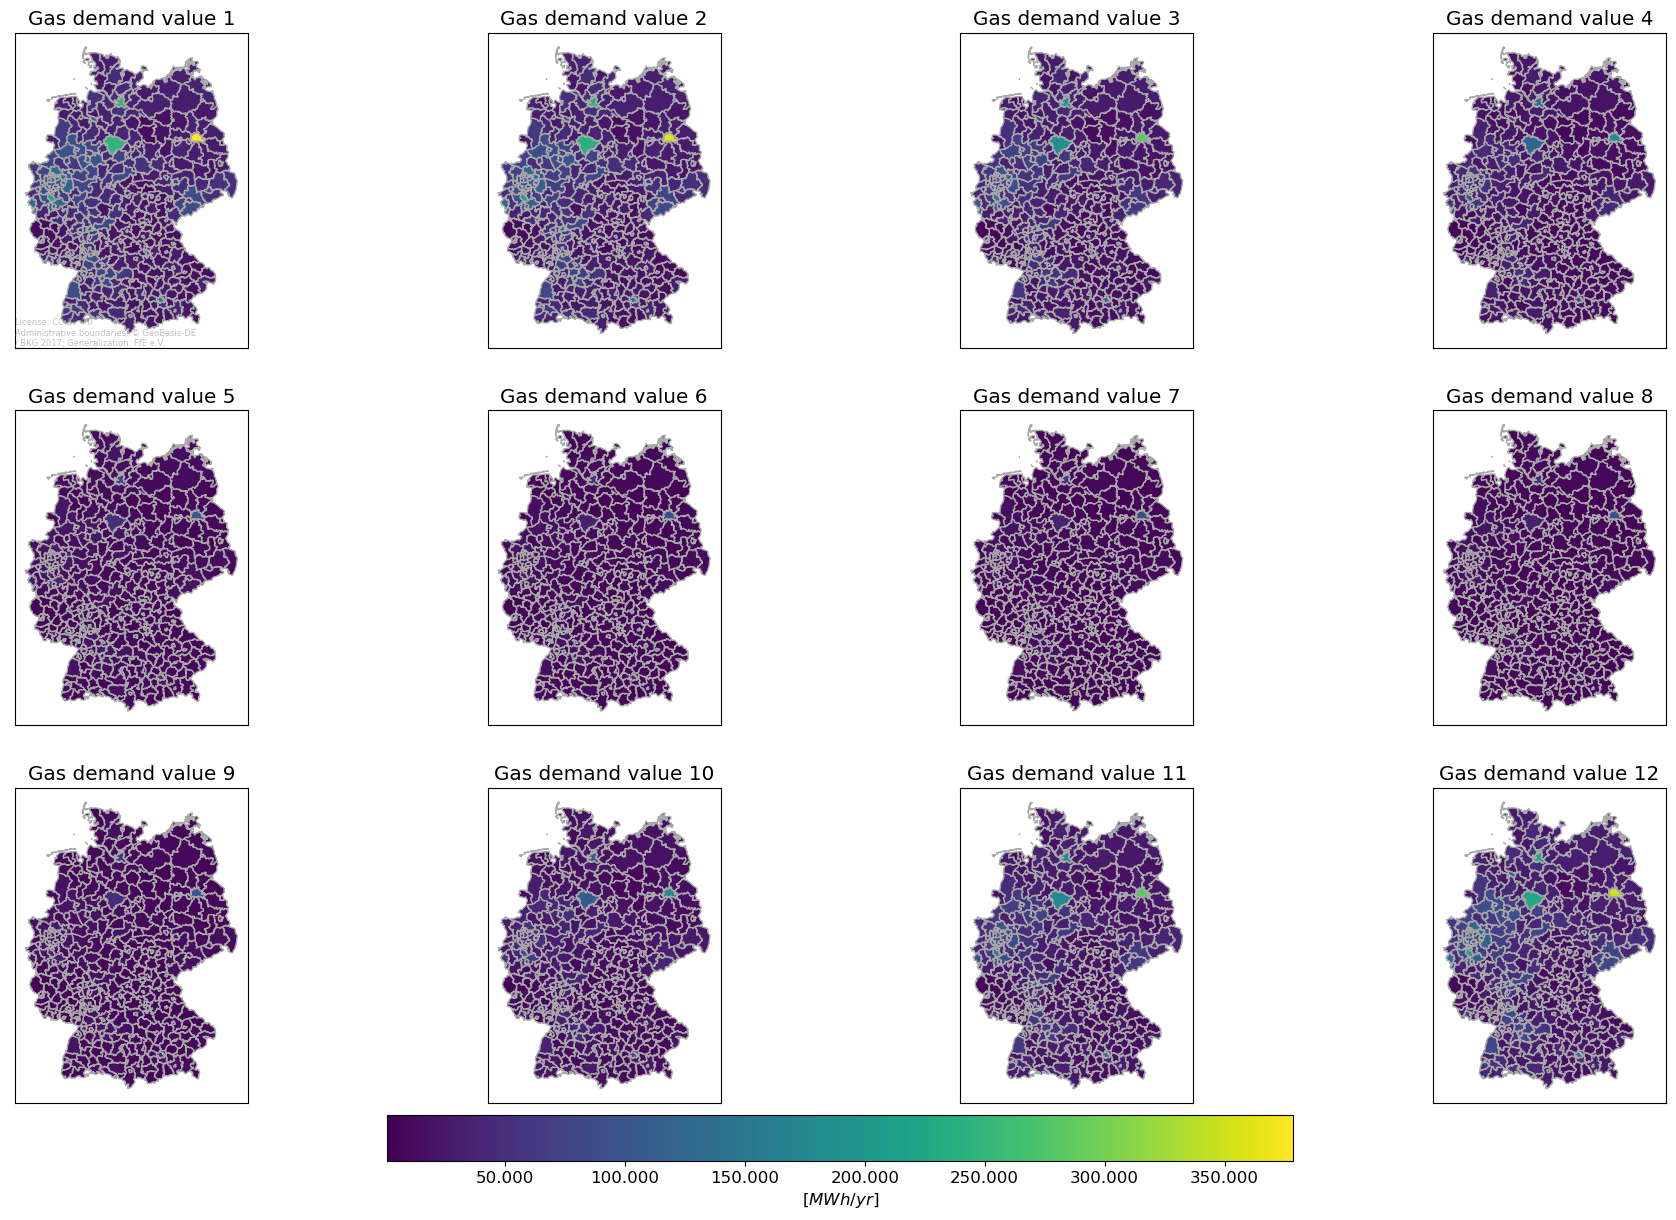

In [41]:
_, _ = plot.choropleth_map(gasDemandGrouped, axtitle = "Gas demand", unit= "MWh/yr", relative = False) # Relative = divide by area

## Industrial demand

As previously, we bring the industry demand and merge the data.

In [42]:
files = ["amonia.json", "refineries.json", "steel.json"]

importData = []

for file in files:
    with open(f"project_data/in/Industries/{file}", 'r', encoding = "utf-8") as f:
        importData.append(json.load(f))

toDelete = []
points = []

i = 0
for dataE in importData:
    temp = []
    for element in dataE:
        if (element["Latitude"] == ""):
            toDelete.append(element)
            continue

        if (i == 1 and element["Product"] != "Crude"): # Keep only the crude production
            toDelete.append(element)
            continue

        if (i == 2 and element["Process"] == "Electric"): # Keep only high furnaces
            toDelete.append(element)
            continue

        element["geometry"] = [float(element["Longitude"]), float(element["Latitude"])]

        del element["Latitude"]
        del element["Longitude"]

        temp.append(Point(element["geometry"][0], element["geometry"][1]))
        
    i += 1
    points.append(temp)

for toD in toDelete: # Delete the industry that doesn't have coordinates
    for dataE in importData:
        if (not toD in dataE): continue
        dataE.remove(toD)

amonia = copy.deepcopy(importData[0])
refineries = copy.deepcopy(importData[1])
steel = copy.deepcopy(importData[2])

aPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[0]), crs = "EPSG:4326")
rPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[1]), crs = "EPSG:4326")
sPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[2]), crs = "EPSG:4326")

aPoints = aPoints.to_crs("EPSG:25832")
rPoints = rPoints.to_crs("EPSG:25832")
sPoints = sPoints.to_crs("EPSG:25832")

# The production is in ton_product/yr so we must transform them into kgH2/d
# We have : ton -> kg (* 1000) , ratio H2/product (x / y) , year -> day (/ 365)

aPoints["consumption"] = [(int(a["Production"]) * 1000 * 176.14 / 1000 / 365) for a in amonia]          # In kgH2 / d
rPoints["consumption"] = [(int(r["Production"]) * 1000 * 1.02 / 227.69 / 365) for r in refineries]      # In kgH2 / d
sPoints["consumption"] = [(int(s["Production"]) * 1000 * 0.97 * 54.171367 / 1000 / 365) for s in steel] # In kgH2 / d

# Find the NUTS3 district where they lay in
aPoints = gpd.sjoin(aPoints, nuts).drop(columns = ['geometry'])
rPoints = gpd.sjoin(rPoints, nuts).drop(columns = ['geometry'])
sPoints = gpd.sjoin(sPoints, nuts).drop(columns = ['geometry'])

# Re-structure the dataframes
aPoints = aPoints[['index_right', 'consumption']].rename(columns = {'index_right' : 'nuts3'})
rPoints = rPoints[['index_right', 'consumption']].rename(columns = {'index_right' : 'nuts3'})
sPoints = sPoints[['index_right', 'consumption']].rename(columns = {'index_right' : 'nuts3'})

# Distribute the production through out the year
daysMonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for t in range(1, 13):
    aPoints[f'value {t}'] = aPoints['consumption'] * daysMonth[t - 1]
    rPoints[f'value {t}'] = rPoints['consumption'] * daysMonth[t - 1]
    sPoints[f'value {t}'] = sPoints['consumption'] * daysMonth[t - 1]

aPoints.drop(columns = ['consumption'], inplace=True)
rPoints.drop(columns = ['consumption'], inplace=True)
sPoints.drop(columns = ['consumption'], inplace=True)

In [43]:
def computeHydrogenDemand(b, nuts, etaH2 = 0.83, etaCH4 = 0.94, industry = True, c_th = [0.5] * 12):
    """Compute the monthly hydrogen demand per district
    
    Arguments:
        - b        : blending percentage (0 - 1] where 0 is pure CH4 and 1 is pure H2
        - nuts     : the NUTS 3 dataframe containing the MultiPolygons (nuts = data.database_shapes())
        - etaH2    : (optional) efficiency of hydrogen boiler
        - etaCH4   : (optional) efficiency of natural gas boiler
        - industry : (optional) does industry have to be taken into consideration
        - c_th     : the threshold per month (default = 50% all year)
    
    Outputs:
        - threshold      : dataframe with the amount of hydrogen that should be produced per month in kgH2
        - hydrogenDemand : dataframe with the amount of hydrogen that each region demands at each month in kgH2
        - centroidData   : dataframe with 3 columns. The first two have the centroid coordinates of each nuts3 district, 
                           the other has the demand of that region at peak demand month 
        - max_period     : month where peak demand is achieved [1, 12]
    """
    
    hydrogenDemand = gasDemandGrouped * 1000 # kWh/yr

    HVch4 = 14.583 # kWh / kgCH4
    HVh2  = 33.33  # kWh / kgH2
    
    #etaH2  = 0.83 # https://ieeexplore.ieee.org/abstract/document/7275758
    #etaCH4 = 0.94
    
    hydrogenDemand = hydrogenDemand / ( ( ( (1 - b) / b) * HVch4 * etaCH4) + (HVh2 * etaH2)) # Now it is in kgH2/month_t
    
    for t in range(1, 13):
        hydrogenDemand[f"value {t}"] = pipesDestination["comingIn"] * hydrogenDemand[f"value {t}"]
        
        if (not industry): continue
        
        for index, row in aPoints.iterrows():
            hydrogenDemand.loc[row["nuts3"], f"value {t}"] += row[f"value {t}"]
        
        for index, row in rPoints.iterrows():
            hydrogenDemand.loc[row["nuts3"], f"value {t}"] += row[f"value {t}"]
        
        for index, row in sPoints.iterrows():
            hydrogenDemand.loc[row["nuts3"], f"value {t}"] += row[f"value {t}"]
    
    if ("XX" in list(hydrogenDemand.index)): hydrogenDemand.drop("XX", inplace = True)
    
    hydrogenMonth = hydrogenDemand.sum(axis=0)
    threshold = pd.DataFrame(index = ["threshold"], columns = [f"value {t}" for t in range(1, 13)])

    for t in range(1, 13):
        threshold[f"value {t}"] = c_th[t-1] * hydrogenMonth[f"value {t}"]
    
    thrls = [int(threshold[f"value {t}"]) / daysMonth[t-1] for t in range(1, 13)] # Hydrogen threshold per month in kgH2/d

    max_period = thrls.index(max(thrls)) + 1 # The largest period is during January

    # Data for finding the centroids : coord_x ¦ coord_y ¦ hydrogen_demand
    centroidData = np.column_stack((nuts.centroid.x, nuts.centroid.y, hydrogenDemand[f"value {max_period}"].values)) 
    
    return threshold, hydrogenDemand, centroidData, max_period

In [44]:
def computeThreshold(hydrogenDemand, month, perc = 0.75, ref_thrld = None):
    """ Function to distribute the threshold during the year with respect to a month "month". It takes the demand at month
        "month" and multiplies it times the percentage "perc" to compute the reference threshold. Then, for a given month,
        if its demand times "perc" is lower than the reference threshold, the threshold for that month is "perc" times the
        demand and we set maxOut to True to not limit the demand (since the capacity to give more hydrogen is there). If the
        demand times "perc" is higher, we set the threshold for that month to the reference threshold
    Arguments:
        - hydrogenDemand : the hydrogen demand computed from the function computeHydrogenDemand
        - month          : the month that we want to consider as reference [1, 13]
        - perc           : the percentage perc of the demand that we consider to AT LEAST be satisfied (default = 75%)
        - ref_thrld      : (optional) instead of using a month as a reference, one can set the reference threshold manually
    
    Outputs:
        - threshold : the minimum threshold to be achieved per month
        - maxOut    : tells the load distributor if it can max out on the demand in order to fully use the plants
    """
    
    monthlyDemand = pd.DataFrame(hydrogenDemand.sum(axis=0)).T.rename(index={0: "demand"}) # Bring the monthly demand in kgH2/month
    
    if (ref_thrld is None): ref_thrld = perc * monthlyDemand[f"value {month}"]["demand"] # Set up the reference value

    # Init the return variables
    maxOut = [False] * 12
    threshold = monthlyDemand.copy().rename(index={"demand": "threshold"})

    for t in range(1, 13):
        if (perc * monthlyDemand[f"value {t}"]["demand"] < ref_thrld):                  # If the available hydrogen demand is lower than the reference threshold, then the threshold for that month should be smaller, but we can max out if possible (don't limit production, use plants to their fullest)
            threshold[f"value {t}"]["threshold"] = perc * monthlyDemand[f"value {t}"]
            maxOut[t-1] = True
        else: threshold[f"value {t}"]["threshold"] = ref_thrld # If the available demand is higher than the reference threshold, then set the threshold to the reference threshold

    return threshold, maxOut, ref_thrld

## Demand analysis

If we analyse the yearly demand of hydrogen considering 100% blending (meaning no natural gas), we find that the total hydrogen demand reaches 128 TWh. Which is close to the expected demand of 130 TWh found in [this](https://www.reuters.com/business/energy/german-cabinet-approves-updated-national-hydrogen-strategy-2023-07-26/) article.

> But even with doubling the country's domestic electrolysis capacity target for 2030 to at least 10 gigawatts (GW), Germany will need to import around 50% to 70% of its hydrogen demand, forecast at 95 to 130 TWh in 2030, the strategy showed.

In [45]:
_, hydrogenDemand, _, _ = computeHydrogenDemand(1, nuts, industry=False)
hydrogenDemand.sum().sum() * 33.33 / 1e9 #  kgH2/d -> kWh/d -> TWh/yr

98.28093198199548

## CAPEX, OPEX and TOTEX

With the hydrogen demand computed, we can declare the equations for the CAPEX, OPEX and TOTEX.

### CAPEX

The CAPEX is defined as the CAPital EXPenditures, that is, everything that needs to be bought. The CAPEX will depend on the daily production of hydrogen and won't scale linearly. Instead, it will follow a curve with exponent 0.6, making it less expensive to build a plant with double the capacity than two plants with equal capacity.

In [46]:
with open("project_data/in/connections_O_10.json", 'r') as file:
    Connections = json.load(file)

Import the weather data that will be used to compute the OPEX

In [47]:
solar_irr = gpd.read_file("project_data/in/WeatherData/weatherData_2022.geojson").drop(columns = ["geometry", "std_irr"])
solar_irr["mean_irr"] = solar_irr["mean_irr"].apply(lambda x: json.loads(x)) # Transform the list from str to list. It is stored as a string

solar_irr.head()

,nuts3,mean_irr
0,DE111,"[12.947962085308056, 28.988862559241703, 76.04..."
1,DE112,"[14.930658105939004, 29.198876404494385, 74.24..."
2,DE113,"[14.731011058451816, 29.061595576619276, 78.27..."
3,DE114,"[14.036507936507936, 26.150539682539684, 78.67..."
4,DE115,"[10.229955817378498, 26.00743740795287, 74.579..."


In [48]:
districtsCentroids = gpd.GeoDataFrame(geometry = nuts.centroid, crs = "EPSG:25832")

def createCentroidData(hydrogenDemand, nuts):
    """Returns the serviceable demand from each district
    Arguments:
        - hydrogenDemand : the hydrogen demand as computed from computeHydrogenDemand
    
    Outputs:
        - new_centroidData : the centroid data computed from the producers
    """
    
    hydrogenYearly = hydrogenDemand.sum(axis=1)
    new_centroidData = pd.DataFrame(hydrogenYearly.copy()).rename(columns = {0: 'demand'})
    new_centroidData['demand'] = np.zeros(401)

    for org in Connections:
        currentVal = 0
        for dest in hydrogenYearly.index:
            if dest in Connections[org] and Connections[org][dest] is not None:
                currentVal += hydrogenYearly[dest]
    
        new_centroidData.loc[org, 'demand'] = currentVal
    
    new_centroidData = np.column_stack((nuts.centroid.x, nuts.centroid.y, new_centroidData['demand'].values)) 
    
    return new_centroidData

def computeCentroids(n, centroidData):
    """Function to find the centroids of the clusters
    Arguments:
        - n            : the number of custers to calculate
        - centroidData : matrix of 3 columns, the two first have the x and y coordinates of the points. The last has the weights
    
    Outputs:
        - The centroids of the weigthed clusters
    """
    centroidData[:, 2] /= np.max(centroidData[:, 2]) # Normalize the energy demand
    
    weights = centroidData[:, 2] # Create a weight array where the weight is the energy demand
    
    # Perform weighted k-means clustering
    kmeans = KMeans(n_clusters = n, random_state = 0)
    kmeans.fit(centroidData[:, :2], sample_weight=weights)

    return kmeans.cluster_centers_ # Return the centroids of the clusters

def annualization(n = 25, i = 0.05):
    """Function to compute the annualization factor τ
    Arguments:
        - n : years to pay the loan (default = 25 years)
        - i : interest of the loan  (default = 5%)
    
    Outputs:
        - τ : the annualization factor 
    """
    return i * (1 + i)**n / ( (1 + i)**n - 1)

def electrolysisCAPEX(outC):
    """ Computes the CAPEX for a single electrolysis plant
    Arguments:
        - outC : output capacity expressed in kgH2/d
    
    Outputs:
        - CAPEX : of such a plant in USD$2022
    """
    m = outC / 24 # kg/hr

    CAPEX = 224.49 * m**(0.6156) # https://www.nrel.gov/docs/fy09osti/44103.pdf p.21
    CAPEX *= 1000 # In 2008 dollars

    CEPCI2022 = 798.3 # 07.2023
    CEPCI2008 = 575.4 #    2008

    return CAPEX * (CEPCI2022 / CEPCI2008)

### Load distribution and CAPEX calculation

Here we divide the load of all the plants as evenly as possible.

In [49]:
def getDistancePath(path): # Returns the length of a path by adding the length between all the points inside of a path
    """ Returns the distance of a path
    Arguments:
        - path : a list containing the path followed from a district of origin A to a district of arrival Z
                 For example [A, G, R, Z] does the following [A, G] + [G, R] + [R, Z].
    
    Outputs:
        - distance : The total length of the path in km
    """
    distance = 0
    
    for i in range(len(path) - 1):
        distance += pipesLengths[path[i]][path[i + 1]]
    
    return distance

def getDestinations(node): # Returns all the districts accessible to a district
    """ Returns all the possible districts that can be reached from a starting node 'node'
    Arguments:
        - node : the starting node
    
    Outputs:
        - temp : a list containing all the districts that can be reached from the node 'node' via pipes
    """
    temp = []
    
    for n in Connections[node]:
        if (Connections[node][n] != None): temp.append(n)
    
    return temp

districtsCentroids = gpd.GeoDataFrame(geometry = nuts.centroid, crs = "EPSG:25832")

def computePlantsCapex(plantsLocations, hydrogenDemand, threshold, max_period, maxOut = [False] * 12):
    """ Find the capacity for each plant, as well as what districts it serves
    Arguments:
        - plantsLocations : a list containing the locations of the districts where the plants are to be installed
        - hydrogenDemand  : dataframe with the amount of hydrogen that each region demands at each month in kgH2/month
        - threshold       : dataframe with the amount of hydrogen that should be produced per month in kgH2/month
        - max_period      : month where peak demand is achieved [1, 12] ¦ if the threshold has been computing using the
                            function computeThreshold, "max_period" becomes the month used, so that the capacity is sized
                            acording to that month
        - maxOut          : (optional) do we limit the production or let it max out
    
    Outputs:
        - CAPEX         : a list containing the CAPEX of each plant in USD$2022
        - sum(CAPEX)    : the sum of all the CAPEXs, that is, the total CAPEX in USD$2022
        - contributions : the maximum output capacity of each plant in kgH2/day
        - servingPlaces : a list of lists with the districts each plant serves
        - production    : two dimensional list with the production per plant (first axis) and month (second axis) in kgH2/day
    """
    n = len(plantsLocations)
    
    # First we will work with the 
    minProdPerPlant = threshold[f"value {max_period}"]["threshold"] / n / daysMonth[max_period-1] # How much each plant should produce for equal load distribution in kgH2/day
    contributions = [0] * n                                                                       # The maximum capacity of each plant in kgH2/day
    production = []                                                                               # How much each plant produces each month in kgH2/day
    
    # Compute the energy demand without duplicates
    servingPlaces = [getDestinations(plant) for plant in plantsLocations]
    duplicates = [] # Structure : [[index1, index2, NUTS3 district], ...]

    # ================= DUPLICATE REMOVAL PART =================
    # Find the duplicates
    for i in range(n): # For each plant
        for serv in servingPlaces[i]: # For each place that the plant i serves, we need to check if it is already in a different place
            for j in range(i + 1, n):
                if (serv in servingPlaces[j]):
                    duplicates.append([i, j, serv])

    toRemove = [] # Structure : [ [plant (index), location to remove (NUTS3), length],  ...]

    for dup in duplicates:
        dist1 = getDistancePath(Connections[plantsLocations[dup[0]]][dup[2]])
        dist2 = getDistancePath(Connections[plantsLocations[dup[1]]][dup[2]])

        if (dist1 > dist2): toRemove.append([dup[0], dup[2], dist1])
        else:               toRemove.append([dup[1], dup[2], dist2])

    toRemove = sorted(toRemove, key=lambda x: x[2])

    for rem in toRemove:                          # For all the destinations that have to be removed
        if (rem[1] in servingPlaces[rem[0]]):     # If the place to remove is still in the list
            if (len(servingPlaces[rem[0]]) == 1): # If we're going to empty the list

                for i, servs in enumerate(servingPlaces):  # Delete the place from all the other lists
                    if (i == rem[0]): continue             # Not the list that we are going to empty

                    if (rem[1] in servs): servs.remove(rem[1])

            else: servingPlaces[rem[0]].remove(rem[1]) # Otherwise (len(list) > 1) : we can safely delete it
    
    max_energy = [sum(hydrogenDemand.loc[dest, f"value {max_period}"] for dest in servingPlaces[i]) / daysMonth[max_period-1] for i in range(n)]

    # ================= CAPACTIY DISTRIBUTION =================
    excess = 0
    for i in range(n): # Decide the power each one can give (first we compute)
        if (minProdPerPlant <= max_energy[i]):
            contributions[i] = minProdPerPlant
        else:
            contributions[i] = max_energy[i]
            excess += minProdPerPlant - max_energy[i]

            for j in range(i):
                if (contributions[j] < max_energy[j]):
                    additional_contribution = min(max_energy[j] - contributions[j], excess)

                    contributions[j] += additional_contribution
                    excess           -= additional_contribution

                    if (excess == 0): break
    
    # It may happen that all the excess haven't been distributed since the previous loop just goes backwards to not interfere
    if (excess > 0):
        for i in range(n):
            additional_contribution = min(max_energy[i] - contributions[i], excess)

            contributions[i] += additional_contribution
            excess           -= additional_contribution

            if (excess == 0): break # If the excess is already 0, don't bother continuing
    
    # ================= COMPUTE MONTHLY PRODUCTION =================

    c = [contributions[i] / (threshold[f"value {max_period}"]["threshold"] / daysMonth[max_period-1]) for i in range(n)] # Compute how much the plants give during the max_period
    
    # Compute how much each plant produces each month
    for t in range(1, 13): # For each month
        energy_t = [sum(hydrogenDemand.loc[dest, f"value {t}"] / daysMonth[t-1] for dest in servingPlaces[i]) for i in range(n)]  # Demand to each plant in kgH2/day
        threshold_t = [c[i] * threshold[f"value {t}"]["threshold"]  / daysMonth[t-1] for i in range(n)]                                   # Threshold for each plant to meet in kgH2/day
        
        # Sort the plants locations by mean solar radiation at period t
        solar_irr_t = [irr[t - 1] for irr in list(solar_irr[solar_irr['nuts3'].isin(plantsLocations)]["mean_irr"])] # Solar irradiation for period t and the plants locations
        
        sorted_lists = sorted(zip(solar_irr_t, plantsLocations), reverse=True)
        _, solar_locations = map(list, zip(*sorted_lists))
        
        # Production distribution
        
        excess_t = 0
        
        prod = [0] * n
        
        if (maxOut): # ---------- If we can max out on production ----------
            for i in range(n):
                if (energy_t[i] > contributions[i]):
                    prod[i] = contributions[i]
                else:
                    prod[i] = energy_t[i]
        
        else:        # ---------- If we can't max out on production and must apply the thresholds ----------
            for i in range(n): # For each plant
                if (energy_t[i] > threshold_t[i]):            # Not enough demand to cover its part of the threshold
                    prod[i] += threshold_t[i]
                else:
                    prod[i]  += energy_t[i]
                    excess_t += threshold_t[i] - energy_t[i]  # And let the other plants

                    for plant in solar_locations:
                        p = plantsLocations.index(plant)

                        if (p > i): continue # Compute only for previous plants

                        diff = min(min(energy_t[p], contributions[p]) - prod[p], excess_t)

                        prod[p]  += diff
                        excess_t -= diff

                        if (excess_t == 0): break

            if (excess_t > 0):
                for plant in solar_locations:
                    p = plantsLocations.index(plant)

                    diff = min(min(energy_t[p], contributions[p]) - prod[p], excess_t)

                    prod[p]  += diff
                    excess_t -= diff

                    if(excess_t == 0): break
        
        production.append(copy.deepcopy(prod))
        
    # ================= COMPUTE THE CAPEX =================
    CAPEX = [0] * n
    for i in range(len(contributions)):
        CAPEX[i] = annualization() * electrolysisCAPEX(contributions[i])
    
    return CAPEX, sum(CAPEX), contributions, servingPlaces, production

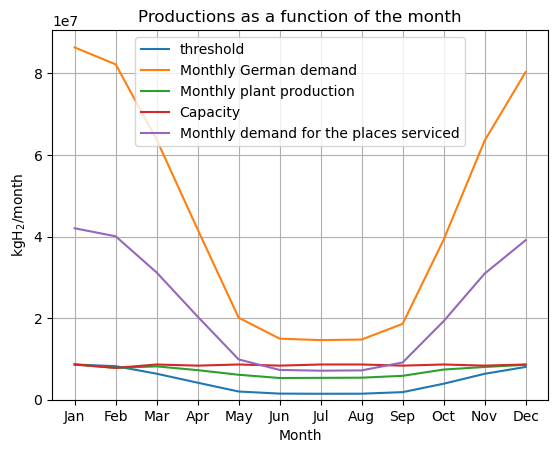

In [50]:
m = 1
b = 0.1
perc = 0.1

_, hy, _, mx = computeHydrogenDemand(b, nuts, industry=False)
th, mo, ref = computeThreshold(hy, month=m, perc = perc)

locations = ['DE239', 'DE94E', 'DE71E', 'DE300', 'DE21H', 'DEF0D', 'DE136', 'DEA36', 'DEG0P', 'DE93B', 'DE21G', 'DE25A', 'DED43', 'DE914', 'DEB3G', 'DE123', 'DE724', 'DEA24', 'DE116', 'DE94A', 'DE928', 'DE80K', 'DEE05', 'DED2C', 'DEG0G', 'DE148', 'DEA2D']
_, _, c, s, p = computePlantsCapex(locations, hy, th, m, mo)

n = len(locations)

energy = []
for t in range(12):
    val = 0
    for i in range(n):
        for j in s[i]:
            val += hy.loc[j, f"value {t+1}"]

    energy.append(val)

fig, ax = plt.subplots(1, 1)
th.T.plot(ax=ax)
plt.plot(hy.sum(axis=0), label = "Monthly German demand")
plt.plot([sum(p[i])*daysMonth[i] for i in range(len(p))], label="Monthly plant production")
plt.plot([sum([c[i] for i in range(n)])*daysMonth[t] for t in range(12)], label="Capacity")
plt.plot(energy, label = "Monthly demand for the places serviced")

plt.xlabel("Month")
plt.ylabel("kgH$_2$/month")
plt.title("Productions as a function of the month")

plt.xticks(range(len(p)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

ax.set_ylim(ymin=0)

plt.legend()
plt.grid()
plt.show()

### OPEX

The OPEX or OPerating EXpenditure is the part that depends on the operations of the 

In [51]:
def electrolysisOPEX(production, location, CAPEX_H2, etaH2 = 0.7, etaPV = 0.1, A_PV = 1.52, b_PV = 1, c_mant = 3.84/12, c_elec = [0.08] * 12):
    """ This function will compute the OPEX of the electrolysing plant plus the CAPEX of the solar panels
        since it will optimize for both
    Arguments:
        - production : the daily production per month expressed in kgH2/day
        - location   : the district where the plant will be placed
        - CAPEX_H2   : the annualized CAPEX of the plant in USD$2022/yr
        - etaH2      : the efficiency of the electrolyser plant (default: 70%)
        - etaPV      : the efficiency of the solar panels from direct solar radiation to electricity (default: 10%)
        - A_PV       : the scaling factor of price for solar panels in USD$2022/kWe (default: 1.52)
        - b_PV       : the power factor of the solar panels (default: 1)
                       Price_PV = A_PV * (Power)**b_PV
        - c_mant     : the maintenance cost for solar panels in USD$2022 (default: 0.32 $/month/kWe)
        - c_elec     : the cost of electricity per month in EUR/kWh (default: 80€/MWh)
    
    Outputs:
        - OPEX  : the OPerational EXpenditure of the plant operation in USD$2022/yr
        - CAPEX : the annualized CAPital EXpenditure of the solar panels in USD$2022/yr
        - A_PV  : the area of solar panels that will be installed in m2
    """
    HHV_H2 = 33.33  # kWh/kgH2
    Pmonthly = [production[t] * daysMonth[t] * HHV_H2 / etaH2 for t in range(12)] # The power consumption in kWhe/month
    
    ref_irr = 1.38 # reference solar irradiation (the power that the surface of the Earth receives) kW_solar/m2
    mean = list(solar_irr[solar_irr["nuts3"] == location]["mean_irr"].values)[0]
    
    maxArea = min(max(Pmonthly) / ref_irr / etaPV / 2, 2e5)    # m2 The maximum PV area. It is equal to the most needed area, or 20 ha
    Areas = np.arange(0, maxArea, maxArea / 1e4)   # m2
    
    tau = annualization() # - return on investment
    
    OPEX_A  = []
    CAPEX_A = []
    TOTEX_A = []
    
    for A in Areas:
        Pinst = etaPV * ref_irr * A # kWe Electric power installed
        
        OPEX_t = [( c_elec[t] * max(Pmonthly[t] - mean[t] * A * etaPV, 0) ) + c_mant * Pinst for t in range(12)]    # OPerational costs
        CAPEX = tau * A_PV * Pinst**b_PV                                                           # CAPital costs of PV
        
        OPEX = sum(OPEX_t) + 0.05 * CAPEX_H2
        
        OPEX_A.append(OPEX)
        CAPEX_A.append(CAPEX)
        
        TOTEX_A.append(OPEX + CAPEX)
    
    minIndex = TOTEX_A.index(min(TOTEX_A)) # Index of the Area with the lowest CAPEX
    
    # Opex has a fixed part and a variable part
    # The fixed part is set at 5% the annualized CAPEX
    # [https://theicct.org/wp-content/uploads/2021/06/final_icct2020_assessment_of-_hydrogen_production_costs-v2.pdf p.27]
    return OPEX_A[minIndex], CAPEX_A[minIndex], Areas[minIndex]

## Optimization

It's time for some minima finding

In [52]:
def create_circle(center_x, center_y, radius, num_points = 25): # Returns a MultiPolygon circle shape
    """Function to create a shapely.geometry.MultiPolygon of a circle
    Arguments:
        - center_x   : x-coordinate of the center of the circle
        - center_y   : y-coordinate of the center of the circle
        - radius     : radius of the circle
        - num_points : (optional) number of points for the resolution of the circle. I found that 25 is good enough
    
    Outputs:
        - a shapely.geometry.MultiPolygon of a circle
    """
    circle_points = []

    for i in range(num_points):
        angle = 2 * np.pi * i / (num_points - 1)

        x = center_x + radius * np.cos(angle)
        y = center_y + radius * np.sin(angle)

        circle_points.append((x, y))

    return MultiPolygon([Polygon(circle_points)])

indexes = list(nuts.index)

def getDistance(point1, point2):
    """Small function to compute the distance between two points
    Arguments:
        - point1 : shapely.geometry.Point 1
        - point2 : shapely.geometry.Point 2
    
    Outputs:
        - The distance between the two points
    """
    return math.sqrt( (point1.x - point2.x)**2 + (point1.y - point2.y)**2 )

def generate_combinations(elements):
    """Function to generate all the possible combinations of the 
    Arguments:
        - elements : a list of lists, where each list in position I has the elements that can be placed in the position I
    
    Outputs:
        - combinations : all the possible combinations
    
    Example:
        - elements     = [['A', 'B'], ['C'], ['D', 'E']]
        - combinations = [['A', 'C', 'D'], ['A', 'C', 'E'], ['B', 'C', 'D'], ['B', 'C', 'E']]
    """
    if (len(elements) == 0): return []

    combinations = [[]]

    for element_list in elements:
        new_combinations = []
        for combination in combinations:
            for element in element_list:
                new_combination = combination.copy()
                new_combination.append(element)
                new_combinations.append(new_combination)
        combinations = new_combinations

    return combinations

def findOptimalLocations(blends, nuts, initR = 10, maxRadius = 1e9, minClusters = 2, maxClusters = 20, outFile = "minTOTEX", custom_th_month = None, custom_th_perc = None):
    """Function to find the optimal districts to place the electrolyzers
    Arguments:
        - blends          : the hydrogen blending percentages that will be considered (0, 1]
        - initR           : the initial radius considered in meters (default = 10)
        - maxRadius       : the maximum radius that can be considered in meters (default = 1e9)
        - minClusters     : the minimum number of clusters to consider (default = 2)
        - maxClusters     : the maximum number of clusters to consider (default = 20)
        - outFile         : the name for the file (default = "minTOTEX")
        - custom_th_month : (optional, for use in dynamic threshold setting) the month that will be taken as a reference for the month [1, 13]
        - custom_th_perc  : (optional, for use in dynamic threshold setting) the percentage of demand that must be satisfied (lower bound)
    
    Ouputs:
        None, it saves the data in files
    """
    for b in blends:  
        # ================= RECOMPUTE THE HYDROGEN DEMAND AND THE THRESHOLD =================
        
        print(f"Updating the hydrogen demand for a {100*b}% of blending")

        threshold, hydrogenDemand, _, max_period = computeHydrogenDemand(b, nuts, industry=True)
        centroidData = createCentroidData(hydrogenDemand, nuts)
        
        if (custom_th_month is not None):
            if (custom_th_perc is not None): threshold, maxOut, _ = computeThreshold(hydrogenDemand, month=custom_th_month, perc=custom_th_perc)
            else:                            threshold, maxOut, _ = computeThreshold(hydrogenDemand, month=custom_th_month)
        
        plantsArea       = [] # The area of the solar panels per plant in m2
        plantsOPEX       = [] # The OPEX of each plant in USD$2022
        plantsCAPEX      = [] # The CAPEX of each plant in USD$2022
        plantsCapacity   = [] # The maximum capacity of each plant in kgH2/day
        plantsServings   = [] # The districts each plant serves
        plantsLocations  = [] # The district where each plant is located
        plantsProduction = [] # The production of the plant per month in kgH2/day
        
        for n in range(minClusters, maxClusters + 1):
            print(f"Finding {n} plants locations")

            currentPrice = float("inf") # Start with a large number to ensure that the first to be a real number is taken
            #currentLength = float("inf")

            plantsArea.append([])
            plantsOPEX.append([])
            plantsCAPEX.append([])
            plantsCapacity.append([])
            plantsServings.append([])
            plantsLocations.append([])
            plantsProduction.append([])
        
            clusterCentroids = computeCentroids(n, centroidData) # Find the n centroids

            R = [initR] * n
            while (currentPrice == float("inf")):

                # ================= FIND THE DISTRICTS TO PLACE THE PLANTS =================
                
                pointsToConsider = []

                for i, point in enumerate(clusterCentroids):
                    pointsToConsider.append([])

                    while (len(pointsToConsider[i]) == 0):
                        pointArea = create_circle(point[0], point[1], R[i])
                        pointsToConsider[i] = gpd.sjoin(nuts, gpd.GeoDataFrame(geometry=[pointArea], index = ["YEP"], crs = "EPSG:25832"), how = "left")
                        pointsToConsider[i] = list(pointsToConsider[i]["index_right"][pointsToConsider[i]["index_right"] == "YEP"].index)

                        # Clean the useless results
                        for j in range(len(pointsToConsider[i]) - 1, -1, -1):
                            if (not pointsToConsider[i][j] in Connections): del pointsToConsider[i][j]

                        if (len(pointsToConsider[i]) == 0): R[i] *= 2
                
                # ================= REMOVE THE DUPLICATES =================
                
                # Check that no two lists have the same locations where a plant can be placed
                toCompare = [] # Structure : [ [index1, index2, NUTS3 district], ...]

                for i in range(n):
                    for point in pointsToConsider[i]:
                        for j in range(i + 1, n):
                            if (point in pointsToConsider[j]):
                                toCompare.append([i, j, point])

                for comp in toCompare:
                    dist1 = getDistance(Point(clusterCentroids[comp[0]][0], clusterCentroids[comp[0]][1]), districtsCentroids.loc[comp[2], "geometry"])
                    dist2 = getDistance(Point(clusterCentroids[comp[1]][0], clusterCentroids[comp[1]][1]), districtsCentroids.loc[comp[2], "geometry"])

                    if (dist1 > dist2): del comp[1]
                    else:               del comp[0]

                # Delete the duplicates that are further from the center
                for comp in toCompare:
                    if (comp[1] in pointsToConsider[comp[0]]): pointsToConsider[comp[0]].remove(comp[1])

                # ================= CHECK EVERY COMBINATION =================

                combinations = generate_combinations(pointsToConsider)
                
                for comb in combinations: # For each point combination
                    
                    # -------------- FIND ALL DISTRICTS SERVED --------------
                    dests = []

                    for i in range(n):
                        dests = dests + getDestinations(comb[i])

                    dests = list(set(dests))
                    
                    # -------------- COMPUTE THEIR HYDROGEN DEMAND --------------
                    enoughDemand = True
                    
                    for t in range(12):
                        val = 0
                        for d in dests:
                            val += hydrogenDemand.loc[d, f"value {t + 1}"]
                        
                        if (val < threshold[f"value {t + 1}"].values[0]):
                            enoughDemand = False
                            break
                    
                    if (not enoughDemand): continue # The production of the plants wouldn't cover 50% of the German demand for all months
                    
                    # -------------- COMPUTE THEIR OPEX, CAPEX AND TOTEX --------------
                    
                    # Compute the CAPEX_H2 of the electrolyzers
                    if (custom_th_month is not None):
                        CAPEXES, _, cap, serving, production = computePlantsCapex(comb, hydrogenDemand, threshold, custom_th_month, maxOut)
                    else:
                        CAPEXES, _, cap, serving, production = computePlantsCapex(comb, hydrogenDemand, threshold, max_period)
                    
                    # This is a sanity check to verify that all locations serve at least one location.
                    # In computePlantsCapex it tries to keep at least one location in the list. However,
                    # it can happen that two locations have one single destination, and it is the same
                    # for both of them. So computePlantsCapex will delete if from one and not the other
                    # but it leaves one list empty.
                    
                    allPopulated = True
                    for serv in serving:
                        if not serv: allPopulated = False
                    
                    if (not allPopulated): continue
                    
                    OPEX  = [0] * n # OPEX  of the plants in USD$2022/yr
                    CAPEX = [0] * n # CAPEX of the plants in USD$2022/yr
                    TOTEX = [0] * n # TOTEX of the plants in USD$2022/yr
                    
                    AREAS = [0] * n # AREAS of the PV solar panels in m2
                    
                    for i in range(n): # Compute the OPEX and the CAPEX_PV of each plant with the data from the CAPEX_H2
                        production_p = [production[t][i] for t in range(12)]
                        OPEX_p, CAPEX_p, AREA_p = electrolysisOPEX(production_p, comb[i], CAPEXES[i])
                        
                        OPEX[i]  = OPEX_p
                        CAPEX[i] = CAPEXES[i] + CAPEX_p
                        
                        TOTEX[i] = OPEX[i] + CAPEX[i]
                        
                        AREAS[i] = AREA_p
                    
                    # -------------- DISTANCES CALCULATIONS FOR min(LENGTH) --------------
                    
                    #distances = [] # List with the distances from every plant to every destination it serves
                    
                    #for i in range(len(comb)):
                    #    for j in range(len(serving[i])):
                    #        distances.append(getDistancePath(Connections[comb[i]][serving[i][j]]))

                    #totalDistance = sum(distances)
                    
                    # -------------- SAVE IF BETTER THAN LAST --------------
                    
                    if (sum(TOTEX) < currentPrice):
                    #if (totalDistance < currentLength):
                        #currentLength = totalDistance
                        currentPrice = sum(TOTEX)
                        
                        plantsArea[-1]       = AREAS
                        plantsOPEX[-1]       = OPEX
                        plantsCAPEX[-1]      = CAPEX
                        plantsCapacity[-1]   = cap
                        plantsServings[-1]   = serving
                        plantsLocations[-1]  = comb
                        plantsProduction[-1] = production
                
                R = [2 * r if r < maxRadius else r for r in R]
                endArray = [r > maxRadius for r in R]
                
                if (sum(endArray) == n):
                    print(f"Failed for {n} plants")
                    break # Limit the radius of the search
            
            optimalPlaces = {}
            
            optimalPlaces["Area"]       = plantsArea
            optimalPlaces["OPEX"]       = plantsOPEX
            optimalPlaces["CAPEX"]      = plantsCAPEX
            optimalPlaces["capacity"]   = plantsCapacity
            optimalPlaces["servings"]   = plantsServings
            optimalPlaces["locations"]  = plantsLocations
            optimalPlaces["production"] = plantsProduction

        with open(f"project_data/out/reducedDemand/optimalPlaces_reduced_{b}{outFile}.json", 'w') as file:
            json.dump(optimalPlaces, file, indent = 4)

# Run the optimization

The optimization is run for diferent values of the minimum demand percentage to be met `perc` and with respect to various months `m`.

The values considered for the minimum demand to be met are 30, 40 and 50%.
The months considered are all, that is, from 1 (Jan) to 13 (Dec).

Then, the optimization is run for hydrogen blending percentages going from 10-100%.

The number of plants considered goes from 20 to 40 plants.

In [53]:
prim = [1, 2, 3, 11, 12]
seg = [4, 5, 6, 7, 8, 9, 10]
todos = prim + seg

print(todos)

for perc in [0.3, 0.5, 0.4]:
    for m in todos:
        print(f"Running for threshold percentage {100*perc}% and month {m:02}")
        findOptimalLocations([0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 1], nuts,
                             outFile=f"_{m:02}_{perc}_minTOTEX", initR=100, maxRadius=1e6,
                             minClusters=20, maxClusters=40, custom_th_month=m, custom_th_perc=perc)

[1, 2, 3, 11, 12, 4, 5, 6, 7, 8, 9, 10]
Running for threshold percentage 30.0% and month 01
Updating the hydrogen demand for a 10.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 25.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants 

Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 65.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 75.0% of blending
Finding 20 plants location

Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 100% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locati

Finding 40 plants locations
Updating the hydrogen demand for a 35.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 50.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants location

Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 85.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 95.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants location

Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 25.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locat

Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 75.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locat

Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 100% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Running for threshold percentage 30.0% and month 09
Updating the hydrogen demand for a 10.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Fin

Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 50.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 65.0% of blendin

Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 95.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locat

Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 25.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 35.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants location

Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 75.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 85.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants location

Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Running for threshold percentage 50.0% and month 04
Updating the hydrogen demand for a 10.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations

Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 65.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locat

Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 95.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 100% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations

Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 35.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 50.0% of blendin

Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 85.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locat

Running for threshold percentage 40.0% and month 01
Updating the hydrogen demand for a 10.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 25.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Fi

Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 65.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 75.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants location

Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 100% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locati

Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 50.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locat

Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 85.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 95.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants location

Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 25.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen d

Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 75.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locat

Finding 40 plants locations
Updating the hydrogen demand for a 100% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Running for threshold percentage 40.0% and month 09
Updating the hydrogen demand for a 10.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Fin

Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 50.0% of blending
Finding 20 plants locations
Finding 21 plants locations
Finding 22 plants locations
Finding 23 plants locations
Finding 24 plants locations
Finding 25 plants locations
Finding 26 plants locations
Finding 27 plants locations
Finding 28 plants locations
Finding 29 plants locations
Finding 30 plants locations
Finding 31 plants locations
Finding 32 plants locations
Finding 33 plants locations
Finding 34 plants locations
Finding 35 plants locations
Finding 36 plants locations
Finding 37 plants locations
Finding 38 plants locations
Finding 39 plants locations
Finding 40 plants locations
Updating the hydrogen demand for a 65.0% of blending
Finding 20 plants locations
Finding 21 plants location